# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [2]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.82, 即時現金賣出: 30.49


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [4]:
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼
#要加find(name='tbody')因為tbody前面有兩個tr,
#若再取hidden-phone print_show會出現兩次None

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='tbody').find_all(name='tr')
for tr in rate_table:
    #print(tr)
    coin=tr.find('div',class_="hidden-phone print_show").text
    print(coin.replace(" ", ""))
    buy=tr.find(attrs={'data-table':'本行現金買入'}).text
    print(buy)
    sell=tr.find(attrs={'data-table':'本行現金賣出'}).text
    print(sell)


美金(USD)

29.82
30.49

港幣(HKD)

3.723
3.927

英鎊(GBP)

39.25
41.37

澳幣(AUD)

20.4
21.18

加拿大幣(CAD)

22.49
23.4

新加坡幣(SGD)

21.71
22.62

瑞士法郎(CHF)

29.92
31.12

日圓(JPY)

0.2669
0.2797

南非幣(ZAR)

-
-

瑞典幣(SEK)

2.84
3.36

紐元(NZD)

19.47
20.32

泰幣(THB)

0.8768
1.0648

菲國比索(PHP)

0.5233
0.6563

印尼幣(IDR)

0.00183
0.00253

歐元(EUR)

32.86
34.2

韓元(KRW)

0.02402
0.02792

越南盾(VND)

0.00093
0.00143

馬來幣(MYR)

6.181
7.825

人民幣(CNY)

4.219
4.381


## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/USD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/USD


<Figure size 720x576 with 0 Axes>

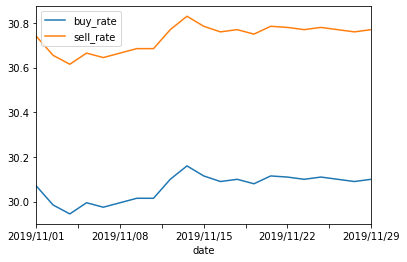

In [6]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
print(history_link)
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-11")
print(quote_history_url)
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    #print(date_string)
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

dic={'date': date_history,'buy_rate':history_buy,'sell_rate':history_sell}
#print(dic)
# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖

In [7]:
def draw(history_table):
    date_history = list()
    history_buy = list()
    history_sell = list()

    for history_rate in history_table:
        # 擷取日期資料
        date_string = history_rate.a.get_text()
        #print(date_string)
        date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
        date_history.append(date)  # 日期歷史資料

        history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
        history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
        history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

    dic={'date': date_history,'buy_rate':history_buy,'sell_rate':history_sell}
    #print(dic)
    # 將匯率資料建成dataframe形式
    HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                        'buy_rate':history_buy,
                                        'sell_rate':history_sell})

    HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
    HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

    # 畫出歷史匯率軌跡圖
    plt.figure(figsize=(10, 8))
    HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
    plt.legend(loc="upper left")
    plt.show()

19

美金(USD)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/USD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/USD


<Figure size 720x576 with 0 Axes>

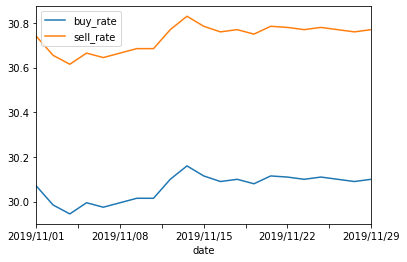


港幣(HKD)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/HKD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/HKD


<Figure size 720x576 with 0 Axes>

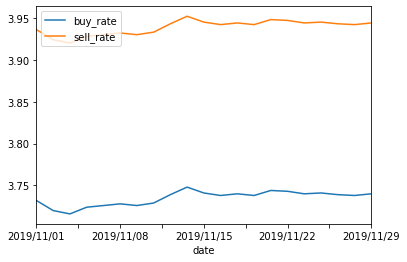


英鎊(GBP)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/GBP" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/GBP


<Figure size 720x576 with 0 Axes>

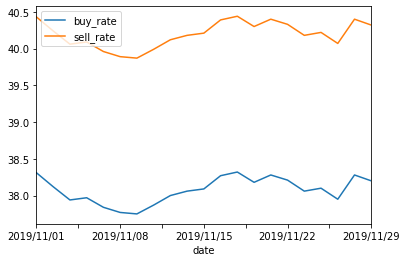


澳幣(AUD)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/AUD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/AUD


<Figure size 720x576 with 0 Axes>

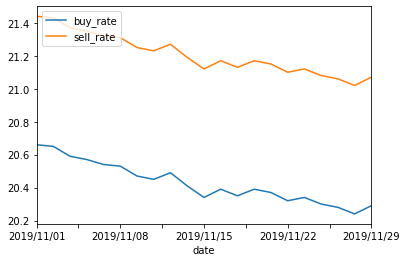


加拿大幣(CAD)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/CAD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/CAD


<Figure size 720x576 with 0 Axes>

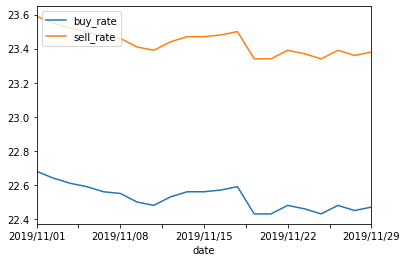


新加坡幣(SGD)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/SGD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/SGD


<Figure size 720x576 with 0 Axes>

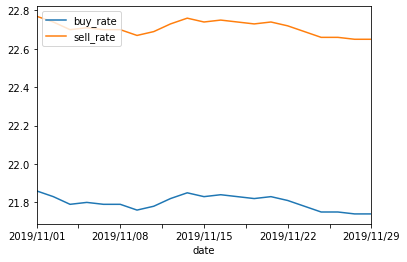


瑞士法郎(CHF)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/CHF" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/CHF


<Figure size 720x576 with 0 Axes>

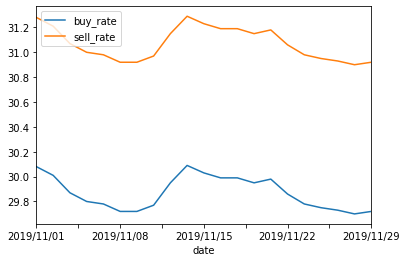


日圓(JPY)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/JPY" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/JPY


<Figure size 720x576 with 0 Axes>

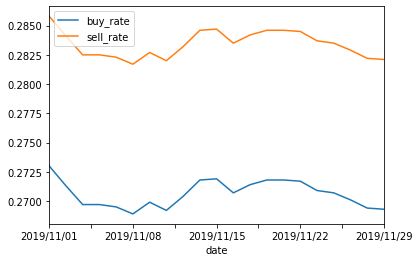


南非幣(ZAR)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/ZAR" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/ZAR


<Figure size 720x576 with 0 Axes>

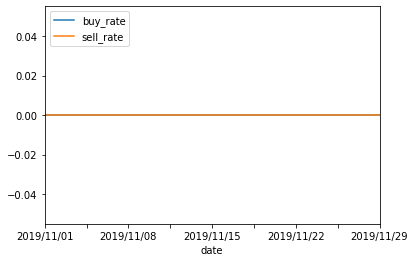


瑞典幣(SEK)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/SEK" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/SEK


<Figure size 720x576 with 0 Axes>

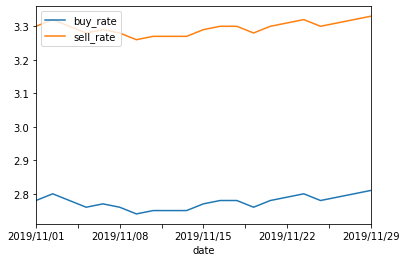


紐元(NZD)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/NZD" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/NZD


<Figure size 720x576 with 0 Axes>

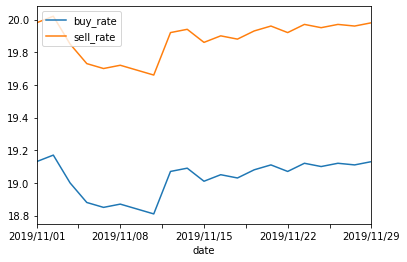


泰幣(THB)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/THB" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/THB


<Figure size 720x576 with 0 Axes>

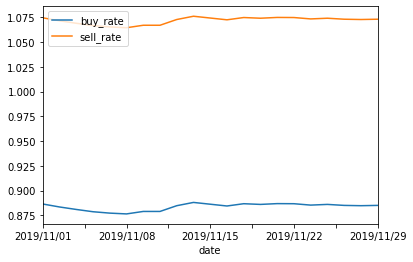


菲國比索(PHP)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/PHP" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/PHP


<Figure size 720x576 with 0 Axes>

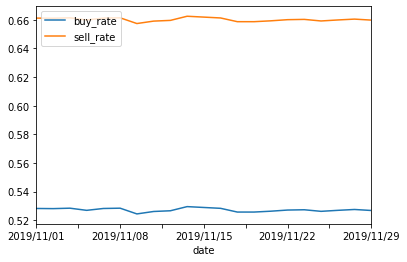


印尼幣(IDR)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/IDR" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/IDR


<Figure size 720x576 with 0 Axes>

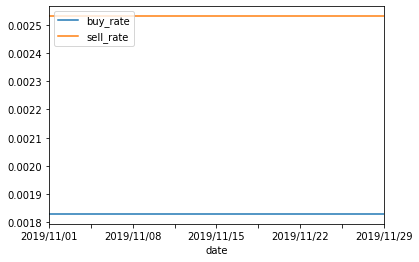


歐元(EUR)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/EUR" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/EUR


<Figure size 720x576 with 0 Axes>

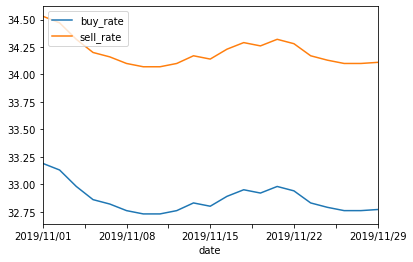


韓元(KRW)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/KRW" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/KRW


<Figure size 720x576 with 0 Axes>

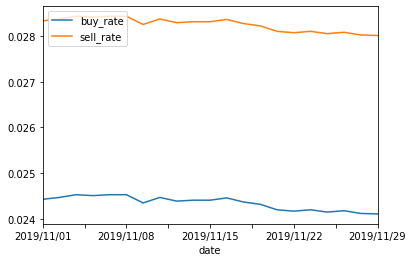


越南盾(VND)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/VND" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/VND


<Figure size 720x576 with 0 Axes>

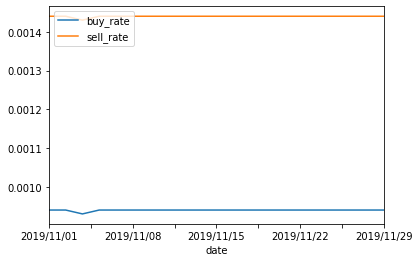


馬來幣(MYR)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/MYR" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/MYR


<Figure size 720x576 with 0 Axes>

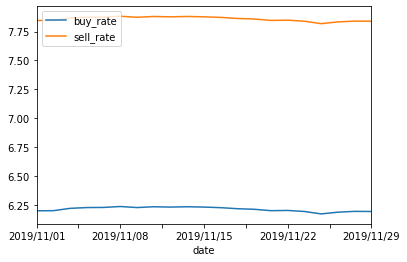


人民幣(CNY)

<td class="text-center print_hide phone-small-font" data-table="歷史匯率"><a href="/xrt/history/CNY" target="_blank">查詢</a></td>
https://rate.bot.com.tw/xrt/quote/2019-11/CNY


<Figure size 720x576 with 0 Axes>

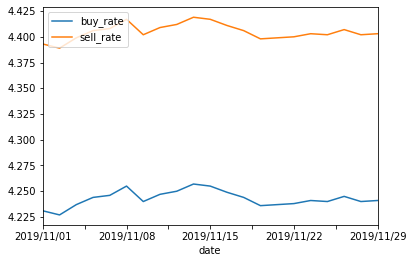

In [9]:
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')
numcountry=len(rate_table)
print(numcountry)
for countryid in range(numcountry):
    # 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
    currency = rate_table[countryid].find(name='div', attrs={'class':'visible-phone print_hide'})
    print(currency.get_text().replace(" ", ""))  # 貨幣種類

    # 針對美金，找到其「歷史匯率」的首頁 
    history_link = rate_table[countryid].find(name='td', attrs={'data-table':'歷史匯率'})
    print(history_link)
    history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

    #
    # 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
    #
    # 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
    quote_history_url = history_rate_link.replace("history", "quote/2019-11")
    print(quote_history_url)
    resp = requests.get(quote_history_url)
    resp.encoding = 'utf-8'
    history = BeautifulSoup(resp.text, "lxml")
    history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')
    draw(history_table)